In [10]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import os
sc._settings.settings._vector_friendly=True

In [3]:
def preprocess_adata(adata, donor_key, leiden_resolution, use_harmony=True):
    '''
    Performs:
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes,
    3. Principal component analysis
    4. Harmony integration (if use_harmony=True)
    5. Neighbor neighbors computation in Harmony integration embedding or the non-Harmony embedding
    6. Leiden clustering (using the KNN graph)

    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)

    # run without batch key
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    #sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)

    # use harmony if True
    if use_harmony:
        sce.pp.harmony_integrate(adata, donor_key)
        sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    else:
        sc.pp.neighbors(adata, use_rep = "X_pca")

    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)

    # for this script, skip the leiden clustering part
    #sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)

    return(adata)

In [4]:
%%time
adata = sc.read_h5ad("03B_sc_sn_adata.h5ad")
adata

CPU times: user 481 ms, sys: 2.7 s, total: 3.18 s
Wall time: 3.18 s


AnnData object with n_obs × n_vars = 121628 × 16115
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'tech_plus_study', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'scvi_cell_type'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts'

2025-01-14 01:31:07,648 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-14 01:31:14,889 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-14 01:31:15,739 - harmonypy - INFO - Iteration 1 of 10
2025-01-14 01:33:11,705 - harmonypy - INFO - Iteration 2 of 10
2025-01-14 01:35:27,698 - harmonypy - INFO - Iteration 3 of 10
2025-01-14 01:37:40,386 - harmonypy - INFO - Iteration 4 of 10
2025-01-14 01:39:57,891 - harmonypy - INFO - Iteration 5 of 10
2025-01-14 01:42:14,652 - harmonypy - INFO - Iteration 6 of 10
2025-01-14 01:44:52,334 - harmonypy - INFO - Iteration 7 of 10
2025-01-14 01:47:18,139 - harmonypy - INFO - Iteration 8 of 10
2025-01-14 01:49:40,330 - harmonypy - INFO - Converged after 8 iterations


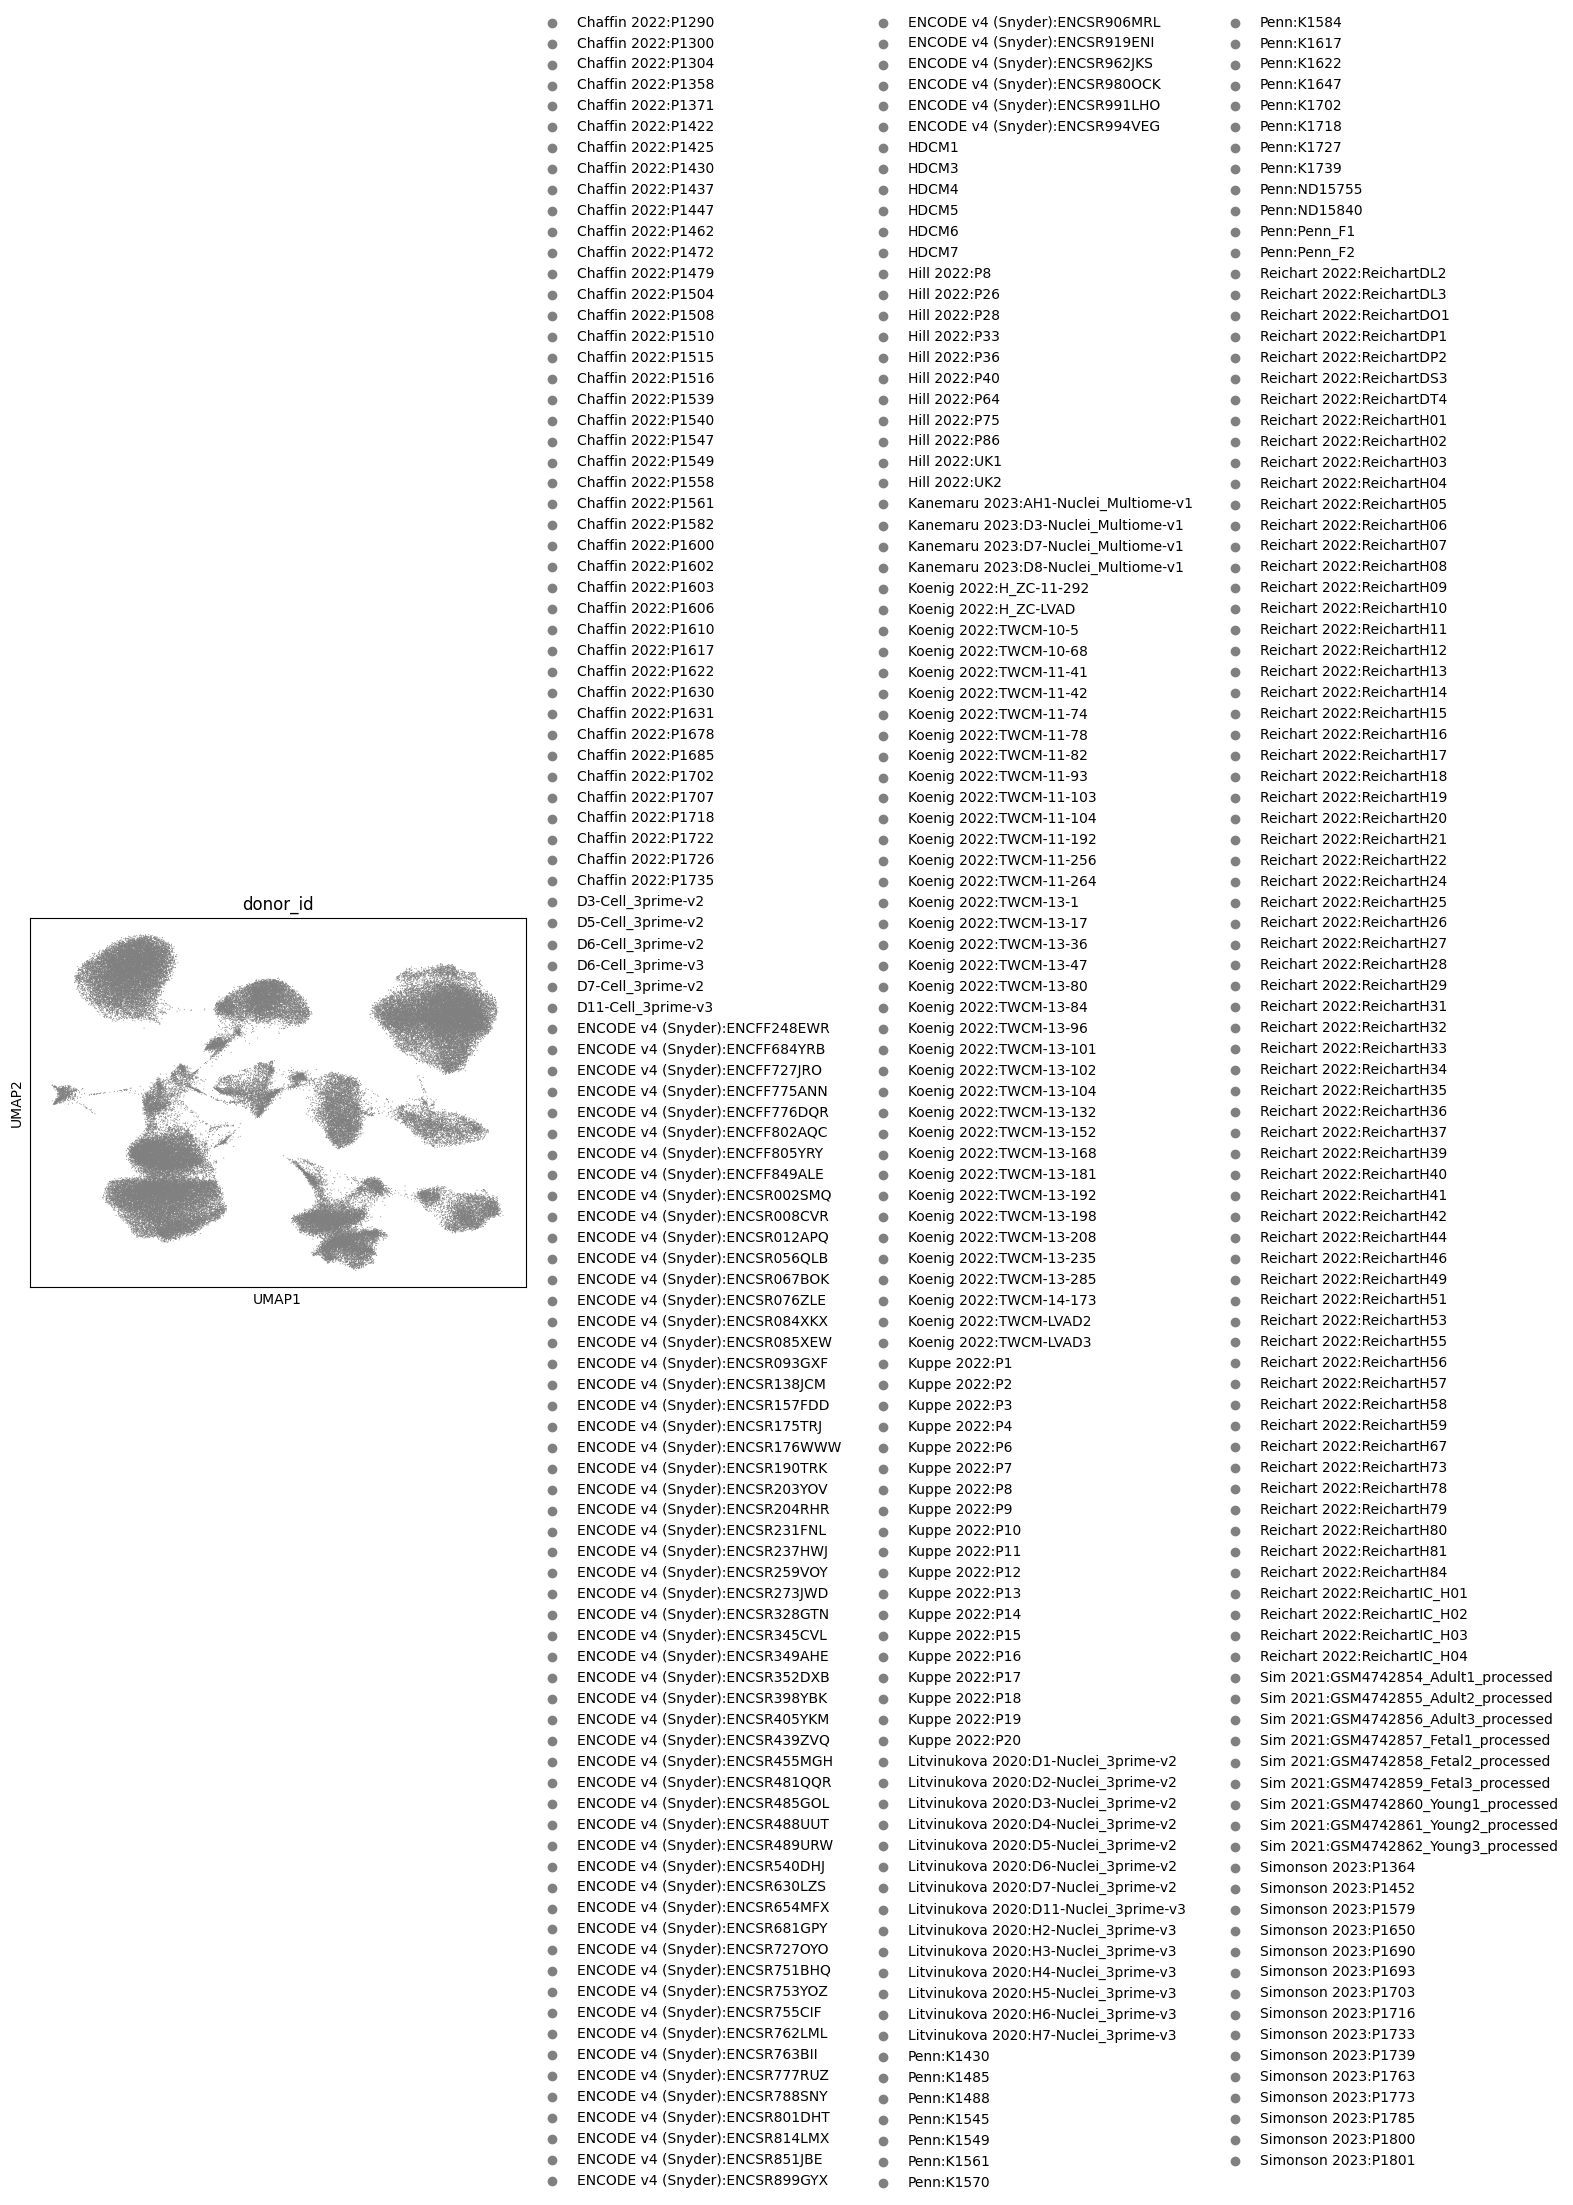

CPU times: user 2h 43min 40s, sys: 8h 14min 49s, total: 10h 58min 29s
Wall time: 21min 2s


In [5]:
%%time
adata.layers['counts'] = adata.X
adata = preprocess_adata(adata, donor_key='donor_id', leiden_resolution=0.5, use_harmony=True)
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap'].copy()

In [6]:
plots_dir = "harmony_plots/"
os.makedirs(plots_dir, exist_ok=True)

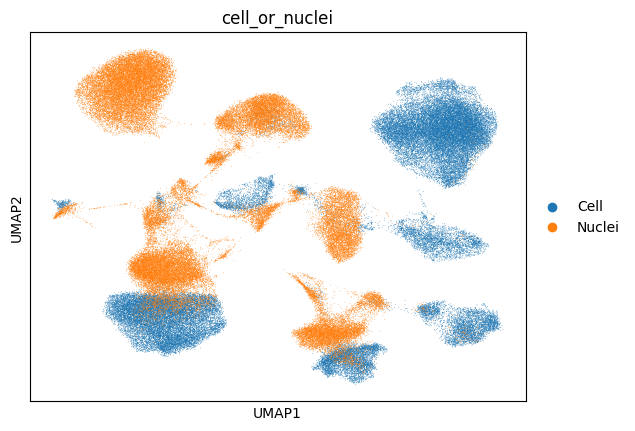

In [7]:
with plt.rc_context():
    sc.pl.umap(adata, color = "cell_or_nuclei", show=False)
    plt.savefig(plots_dir + "UMAP_cell_vs_nuclei.pdf")
    plt.show()

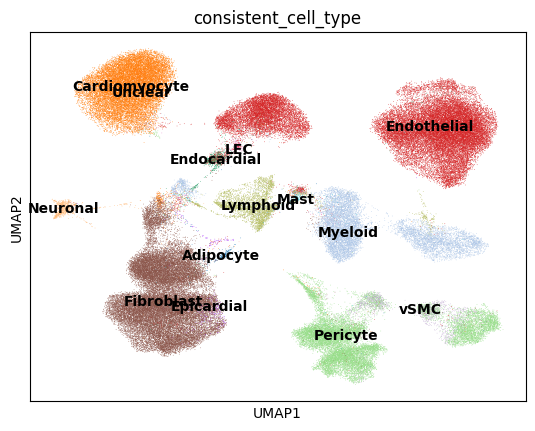

In [8]:
with plt.rc_context():
    sc.pl.umap(adata, color = "consistent_cell_type", legend_loc = 'on data', show=False)
    plt.savefig(plots_dir + "UMAP_cell_type.pdf")
    plt.show()

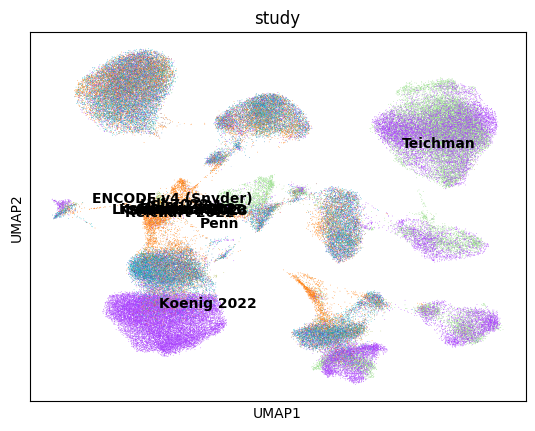

In [9]:
with plt.rc_context():
    sc.pl.umap(adata, color = "study", legend_loc = 'on data', show=False)
    plt.savefig(plots_dir + "UMAP_study.pdf")
    plt.show()

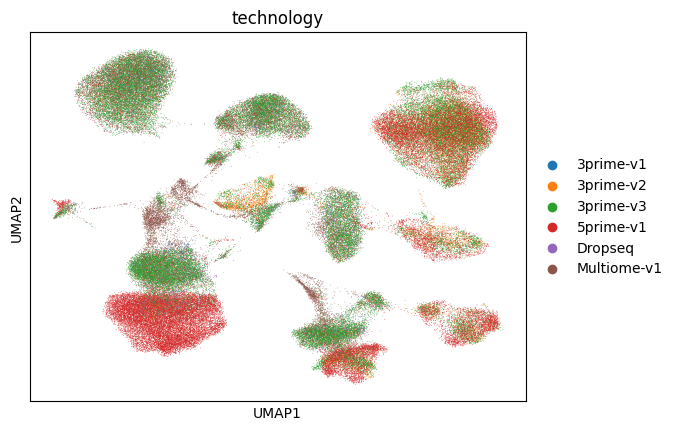

In [10]:
with plt.rc_context():
    sc.pl.umap(adata, color = "technology", show=False)
    plt.savefig(plots_dir + "UMAP_technology.pdf")
    plt.show()

In [18]:
adata.write("04C_harmony_integrated_adata.h5ad")